# Fake News Detection: Can we build a classifier that can accurately detect fake news?

In [1]:
from imports import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rc('figure', figsize=(10, 7))
plt.style.use('fivethirtyeight')

### Initial exploration 

In [2]:
true_df = pd.read_csv('True.csv')

true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [3]:
fake_df = pd.read_csv('Fake.csv')

fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


<AxesSubplot:>

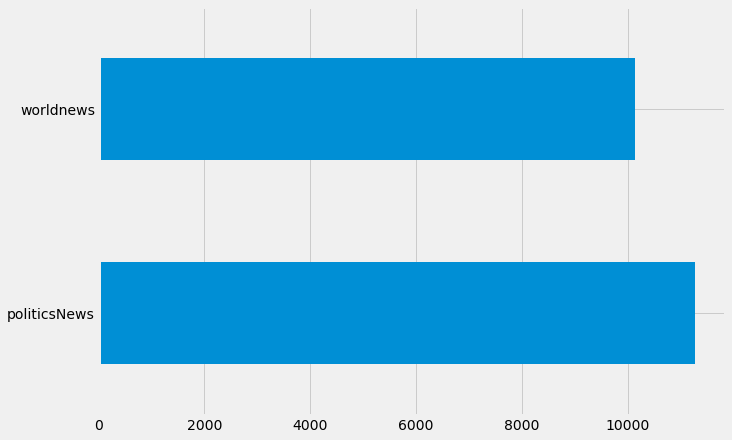

In [6]:
true_df.subject.value_counts().plot.barh()

<AxesSubplot:>

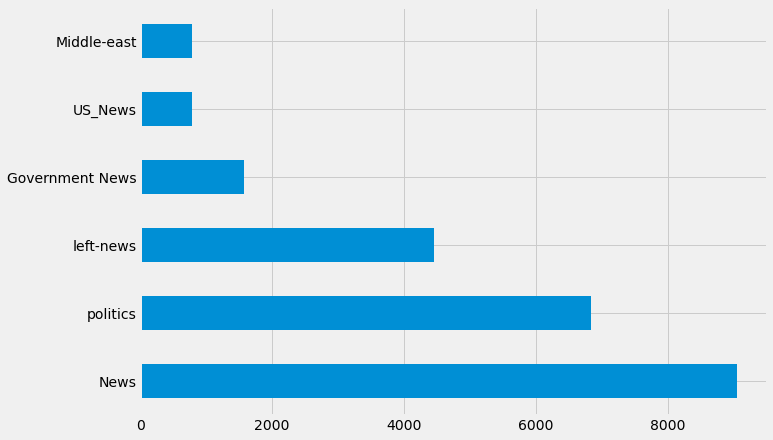

In [7]:
fake_df.subject.value_counts().plot.barh()

In [8]:
print(true_df.text[0])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati

In [9]:
len(true_df.text[0].split())

749

In [10]:
print(fake_df.text[0])

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [11]:
len(fake_df.text[0].split())

495

In [12]:
print(true_df.title[0])
print(fake_df.title[0])

As U.S. budget fight looms, Republicans flip their fiscal script
 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing


### Initial takeaways:

- True news articles have a preamble/external in the format: "CITY (News Association)- "
- There are only two subject types in true articles, but six in fake articles

### Initial data prep/wrangle plan:

- Add a boolean truth value column corresponding to each df
- Standardize columns for ease of access/manipulation (to names that are not reserved words)
- Reorganize subject types
- Prepare text:
    * Make a version of true article that is stripped of externals like "CITY (News Association)- " for ML comparisons
    * Clean fake articles
- Join dfs on axis 0
- Set index to date
- Get word counts for articles (as engineered feature)
    

### Add a boolean truth value column corresponding to each df

In [13]:
# Set truth values for each df
true_df['truth_value'] = True
fake_df['truth_value'] = False


### Standardize columns for ease of access/manipulation (to names that are not reserved words)

In [14]:
# Standardize columns
true_df.rename(columns= {'title':'article_headline', 'text': 'article_body'}, inplace=True)
fake_df.rename(columns= {'title':'article_headline', 'text': 'article_body'}, inplace=True)
# Print out column lists to check
print(f'True DF columns:\n{true_df.columns}')
print(f'Fake DF columns:\n{fake_df.columns}')

True DF columns:
Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value'], dtype='object')
Fake DF columns:
Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value'], dtype='object')


### Reorganize subject types

In [15]:
# Organize subject types in true_df
true_df.subject.replace(to_replace='politicsNews', value='politics', inplace=True)
true_df.subject.replace(to_replace= 'worldnews', value='world', inplace=True)
# Check values
true_df.subject.value_counts()

politics    11272
world       10145
Name: subject, dtype: int64

In [16]:
fake_df.subject.value_counts().index

Index(['News', 'politics', 'left-news', 'Government News', 'US_News',
       'Middle-east'],
      dtype='object')

In [17]:
# Organize subject types in fake_df
fake_df.subject.replace(
    to_replace= ['News', 'politics', 'left-news', 'Government News', 'US_News','Middle-east'],
    value= ['politics', 'politics', 'politics', 'politics', 'world', 'world'],
    inplace= True)

fake_df.subject.value_counts()

politics    21920
world        1561
Name: subject, dtype: int64

### Prepare text:

- Make a version of true article that is stripped of externals like "CITY (News Association)- " for ML comparisons
- Clean articles

In [18]:
# Encode the preamble in 'True' articles with regex to remove it in a later engineered feature
regexp_true = r'\w*\S?\w*\s\(\w*\)\s\S'
#true_df.article_body.str.replace(r'\w*\S?\w*\s\(\w*\)\s\S', '')
import warnings
warnings.filterwarnings('ignore')

In [19]:
import prep

true_df['article_clean'] = true_df.article_body.str.replace(regexp_true, '')
true_df.article_clean = true_df.article_clean.apply(prep.basic_clean)

true_df.head(3)

,article_headline,article_body,subject,date,truth_value,article_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,"December 31, 2017",True,the head of a conservative republican faction...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politics,"December 29, 2017",True,transgender people will be allowed for the fi...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politics,"December 31, 2017",True,the special counsel investigation of links be...


In [20]:
true_df.date.sort_values()

10099        April 1, 2016 
10019        April 1, 2016 
10020        April 1, 2016 
10092        April 1, 2016 
10094        April 1, 2016 
                ...        
20543    September 9, 2017 
20542    September 9, 2017 
20540    September 9, 2017 
20555    September 9, 2017 
20549    September 9, 2017 
Name: date, Length: 21417, dtype: object

In [21]:
fake_df['article_clean'] = fake_df.article_body.apply(prep.basic_clean)

fake_df.head(3)

,article_headline,article_body,subject,date,truth_value,article_clean
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,politics,"December 31, 2017",False,donald trump just couldn t wish all americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,politics,"December 31, 2017",False,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",politics,"December 30, 2017",False,on friday it was revealed that former milwauke...


In [22]:
fake_df.date.sort_values()

9084                                             14-Feb-18
9075                                             15-Feb-18
9076                                             15-Feb-18
9077                                             15-Feb-18
9078                                             15-Feb-18
                               ...                        
17433    https://fedup.wpengine.com/wp-content/uploads/...
15840    https://fedup.wpengine.com/wp-content/uploads/...
15839    https://fedup.wpengine.com/wp-content/uploads/...
17432    https://fedup.wpengine.com/wp-content/uploads/...
21869    https://fedup.wpengine.com/wp-content/uploads/...
Name: date, Length: 23481, dtype: object

In [23]:
fake_rows_todrop = fake_df[fake_df.date.str.contains('https')].index

fake_df = fake_df.drop(labels= fake_rows_todrop)
fake_df.date.sort_values().tail()

4705    September 9, 2016
404     September 9, 2017
405     September 9, 2017
406     September 9, 2017
407     September 9, 2017
Name: date, dtype: object

In [24]:
print(true_df.columns)
print(fake_df.columns)

Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value',
       'article_clean'],
      dtype='object')
Index(['article_headline', 'article_body', 'subject', 'date', 'truth_value',
       'article_clean'],
      dtype='object')


In [25]:
df = pd.concat([true_df, fake_df], axis=0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44889 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_headline  44889 non-null  object
 1   article_body      44889 non-null  object
 2   subject           44889 non-null  object
 3   date              44889 non-null  object
 4   truth_value       44889 non-null  bool  
 5   article_clean     44889 non-null  object
dtypes: bool(1), object(5)
memory usage: 2.1+ MB


,article_headline,article_body,subject,date,truth_value,article_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,"December 31, 2017",True,the head of a conservative republican faction...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politics,"December 29, 2017",True,transgender people will be allowed for the fi...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politics,"December 31, 2017",True,the special counsel investigation of links be...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politics,"December 30, 2017",True,trump campaign adviser george papadopoulos to...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politics,"December 29, 2017",True,president donald trump called on the us posta...


In [26]:
df[df.date.str.contains('MSNBC')]

,article_headline,article_body,subject,date,truth_value,article_clean
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,politics,MSNBC HOST Rudely Assumes Steel Worker Would N...,False,vcrowvccolumn width tdblocktrendingnow limit ...


In [27]:
df = df.drop(labels= [18933])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44887 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_headline  44887 non-null  object
 1   article_body      44887 non-null  object
 2   subject           44887 non-null  object
 3   date              44887 non-null  object
 4   truth_value       44887 non-null  bool  
 5   article_clean     44887 non-null  object
dtypes: bool(1), object(5)
memory usage: 2.1+ MB


In [28]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44887 entries, 2017-12-31 to 2016-01-12
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_headline  44887 non-null  object        
 1   article_body      44887 non-null  object        
 2   subject           44887 non-null  object        
 3   date              44887 non-null  datetime64[ns]
 4   truth_value       44887 non-null  bool          
 5   article_clean     44887 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 2.1+ MB


,article_headline,article_body,subject,date,truth_value,article_clean
date,,,,,,
2017-12-31,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politics,2017-12-31,True,the head of a conservative republican faction...
2017-12-29,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politics,2017-12-29,True,transgender people will be allowed for the fi...
2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politics,2017-12-31,True,the special counsel investigation of links be...
2017-12-30,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politics,2017-12-30,True,trump campaign adviser george papadopoulos to...
2017-12-29,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politics,2017-12-29,True,president donald trump called on the us posta...


In [29]:
df = df.sort_index(ascending=True)

df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44887 entries, 2015-03-31 to 2018-02-19
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_headline  44887 non-null  object        
 1   article_body      44887 non-null  object        
 2   subject           44887 non-null  object        
 3   date              44887 non-null  datetime64[ns]
 4   truth_value       44887 non-null  bool          
 5   article_clean     44887 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 2.1+ MB


,article_headline,article_body,subject,date,truth_value,article_clean
date,,,,,,
2018-02-18,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,2018-02-18,False,just one more reminder of why president trump ...
2018-02-18,IT BEGINS…RINO MEGA-DONOR Threatens Jeb Bush: ...,A longtime Republican Party donor based in Flo...,politics,2018-02-18,False,a longtime republican party donor based in flo...
2018-02-19,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,2018-02-19,False,ami horowitz is fantastic check out this man o...
2018-02-19,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,politics,2018-02-19,False,if we protect every other government building ...
2018-02-19,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,2018-02-19,False,according to the hill democrat senator bob cas...


In [30]:
df = df.drop(columns= ['date'])
#df.reset_index(inplace=True)
df

,article_headline,article_body,subject,truth_value,article_clean
date,,,,,
2015-03-31,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,False,in case you missed it sen harry reid rnv who a...
2015-03-31,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,False,does anyone really think hillary clinton will ...
2015-03-31,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,False,the irony here isn t lost on us hillary is bei...
2015-03-31,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,False,the irony here isn t lost on us hillary is bei...
2015-03-31,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,False,in case you missed it sen harry reid rnv who a...
...,...,...,...,...,...
2018-02-18,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,False,just one more reminder of why president trump ...
2018-02-18,IT BEGINS…RINO MEGA-DONOR Threatens Jeb Bush: ...,A longtime Republican Party donor based in Flo...,politics,False,a longtime republican party donor based in flo...
2018-02-19,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,False,ami horowitz is fantastic check out this man o...


In [31]:
def get_word_count(col):
    col = pd.Series(col)

    for i in col:
        len(i.split())
    return len(i.split())

df['raw_wd_count'] = df.article_body.apply(get_word_count)
df.head()


,article_headline,article_body,subject,truth_value,article_clean,raw_wd_count
date,,,,,,
2015-03-31,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,False,in case you missed it sen harry reid rnv who a...,123
2015-03-31,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,False,does anyone really think hillary clinton will ...,493
2015-03-31,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,False,the irony here isn t lost on us hillary is bei...,322
2015-03-31,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,False,the irony here isn t lost on us hillary is bei...,322
2015-03-31,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,False,in case you missed it sen harry reid rnv who a...,123


In [32]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39109 entries, 2015-03-31 to 2018-02-19
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_headline  39109 non-null  object
 1   article_body      39109 non-null  object
 2   subject           39109 non-null  object
 3   truth_value       39109 non-null  bool  
 4   article_clean     39109 non-null  object
 5   raw_wd_count      39109 non-null  int64 
dtypes: bool(1), int64(1), object(4)
memory usage: 1.8+ MB


In [33]:
df.article_clean = df.article_clean.apply(prep.tokenize)\
    .apply(prep.remove_stopwords)

df.head(3)

,article_headline,article_body,subject,truth_value,article_clean,raw_wd_count
date,,,,,,
2015-03-31,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,False,case missed sen harry reid rnv announced last ...,123
2015-03-31,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,False,anyone really think hillary clinton come clean...,493
2015-03-31,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,False,irony lost us hillary compared president wante...,322


In [34]:
df['article_stemmed'] = df.article_body.apply(prep.basic_clean)\
    .apply(prep.tokenize)\
        .apply(prep.stem)\
            .apply(prep.remove_stopwords)

df['article_lemmatized'] = df.article_body.apply(prep.basic_clean)\
    .apply(prep.tokenize)\
        .apply(prep.lemmatize)\
            .apply(prep.remove_stopwords)

df.head(3)

,article_headline,article_body,subject,truth_value,article_clean,raw_wd_count,article_stemmed,article_lemmatized
date,,,,,,,,
2015-03-31,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,False,case missed sen harry reid rnv announced last ...,123,case miss sen harri reid rnv announc last week...,case missed sen harry reid rnv announced last ...
2015-03-31,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,False,anyone really think hillary clinton come clean...,493,doe anyon realli think hillari clinton come cl...,doe anyone really think hillary clinton come c...
2015-03-31,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,False,irony lost us hillary compared president wante...,322,ironi lost us hillari compar presid want take ...,irony lost u hillary compared president wanted...


In [35]:
df.to_csv('fake_news_detection.csv', index=False)

End wrangle/prep.

### NLP exploration

- What are the most common words in these articles? 
    - What are the most common words in fake articles?
    - What are the most common words in real articles?

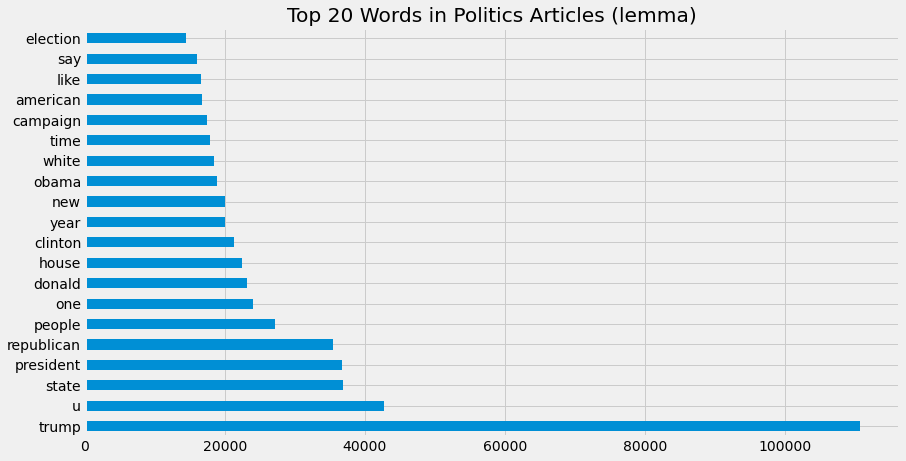

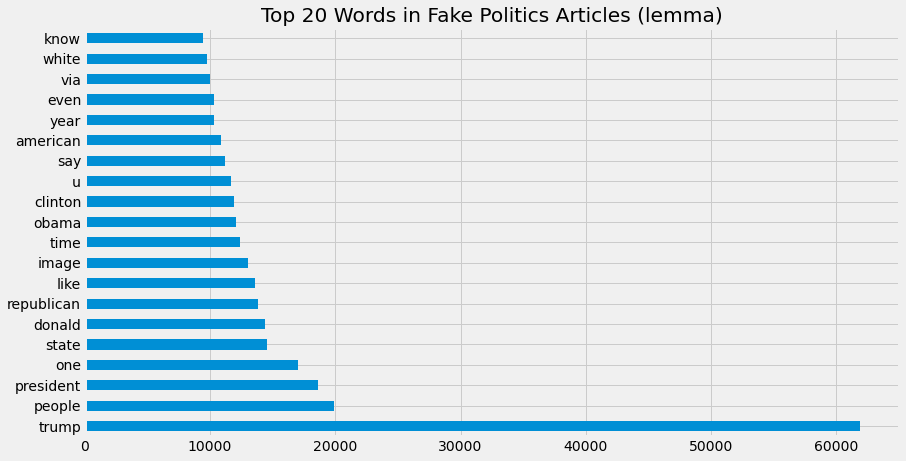

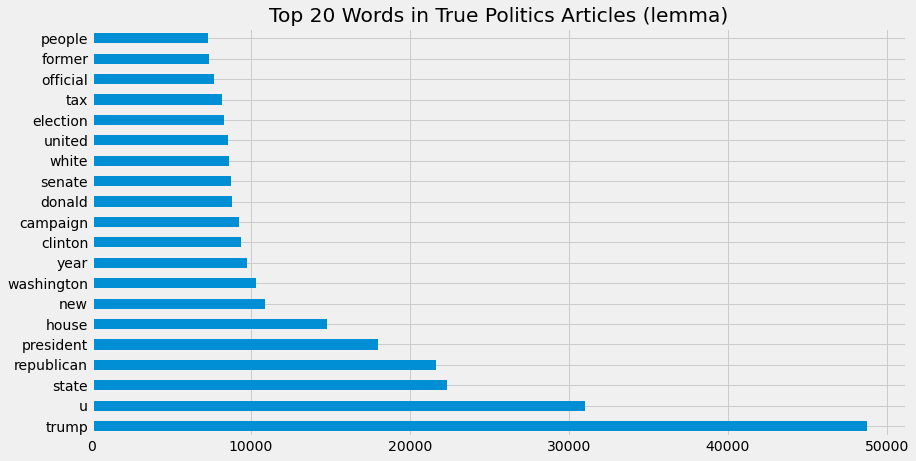

In [36]:
# Make corpus of lemmatized politics articles
pol_lem_corpus = ' '.join(df[df.subject == 'politics'].article_lemmatized)
pol_lem_corpus = pol_lem_corpus.split()
pol_lem_freq = pd.Series(pol_lem_corpus).value_counts()

# Visualize Top 20 most common words in politics articles

plt.figure(figsize=(13,7))
pol_lem_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in Politics Articles (lemma)')

plt.show()


fake_pol_corpus = ' '.join(df[(df.subject == 'politics') & (df.truth_value == False)].article_lemmatized)
fake_pol_corpus = fake_pol_corpus.split()
fake_pol_freq = pd.Series(fake_pol_corpus).value_counts()

plt.figure(figsize= (13,7))
fake_pol_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in Fake Politics Articles (lemma)')

plt.show()

true_pol_corpus = ' '.join(df[(df.subject == 'politics') & (df.truth_value == True)].article_lemmatized)
true_pol_corpus = true_pol_corpus.split()
true_pol_freq = pd.Series(true_pol_corpus).value_counts()

plt.figure(figsize= (13,7))
true_pol_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in True Politics Articles (lemma)')

plt.show()

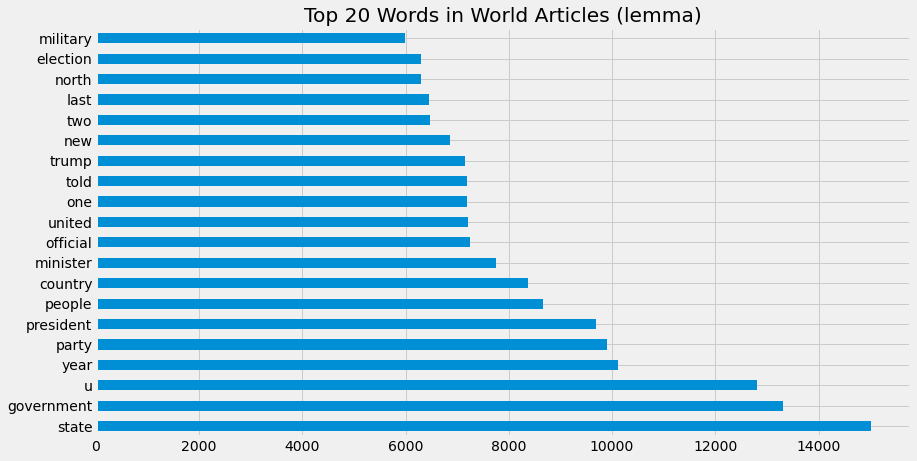

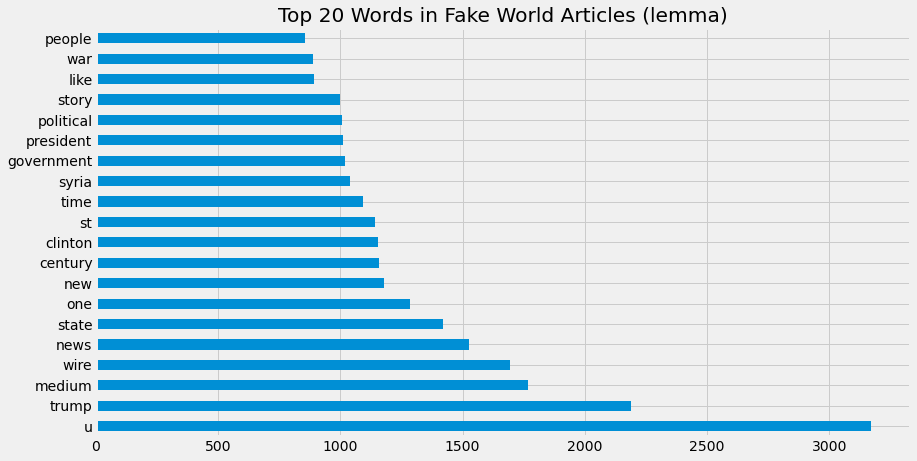

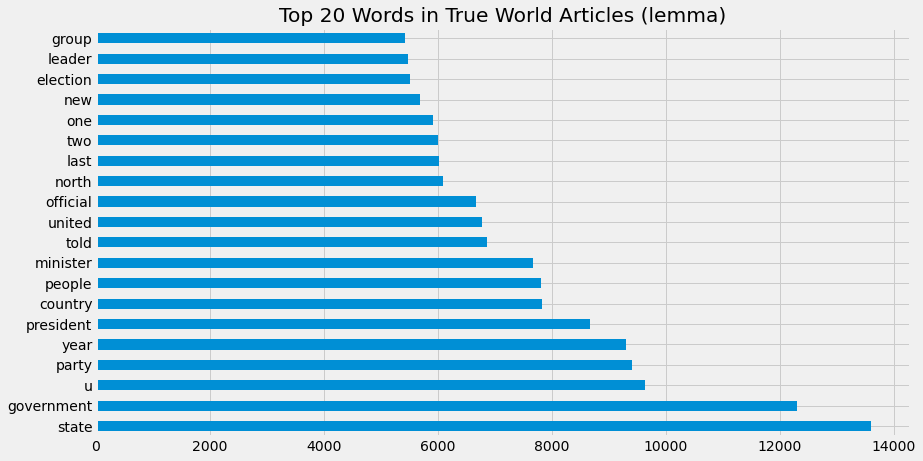

In [37]:
# Visualize top 20 most common words in 'world' subject

# Make corpus of lemmatized world articles
world_lem_corpus = ' '.join(df[df.subject == 'world'].article_lemmatized)
world_lem_corpus = world_lem_corpus.split()
# Get word counts
world_lem_freq = pd.Series(world_lem_corpus).value_counts()

# Visualize top 20 common words in world articles overall
plt.figure(figsize=(13,7))
world_lem_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in World Articles (lemma)')

plt.show()

# Make corpus of lemmatized world articles for fake news subset
fake_world_corpus = ' '.join(df[(df.subject == 'world') & (df.truth_value == False)].article_lemmatized)
fake_world_corpus = fake_world_corpus.split()
fake_world_freq = pd.Series(fake_world_corpus).value_counts()

plt.figure(figsize= (13,7))
fake_world_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in Fake World Articles (lemma)')

plt.show()

# Make corpus of lemmatized world articles for true news subset
true_world_corpus = ' '.join(df[(df.subject == 'world') & (df.truth_value == True)].article_lemmatized)
true_world_corpus = true_world_corpus.split()
true_world_freq = pd.Series(true_world_corpus).value_counts()

plt.figure(figsize= (13,7))
true_world_freq.sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in True World Articles (lemma)')

plt.show()

### Takeaways: 
- 'Trump' appears in five out of six of the above top 20 listings. 
- The letter 'u' appears in all six. Further investigation is necessary, but we must also consider the probability of unigrams' limited usefulness beyond the initial survey of the corpus/sub-corpora.

In [38]:
article_corpora = [pol_lem_corpus, fake_pol_corpus, true_pol_corpus, world_lem_corpus, fake_world_corpus, true_world_corpus]
corpus_title = [
    'politics (lemma)', 
    'fake news politics (lemma)', 
    'true news politics (lemma)', 
    'world (lemma)', 
    'fake news world (lemma)', 
    'true news world (lemma)'
    ]

corpus_title = [title.capitalize() for title in corpus_title]
corpora_labels = pd.DataFrame(zip(corpus_title, article_corpora))
corpora_labels.rename(columns = {0: 'corpus_title', 1: 'corpus'}, inplace=True)


In [39]:
type(corpora_labels.corpus_title)

pandas.core.series.Series

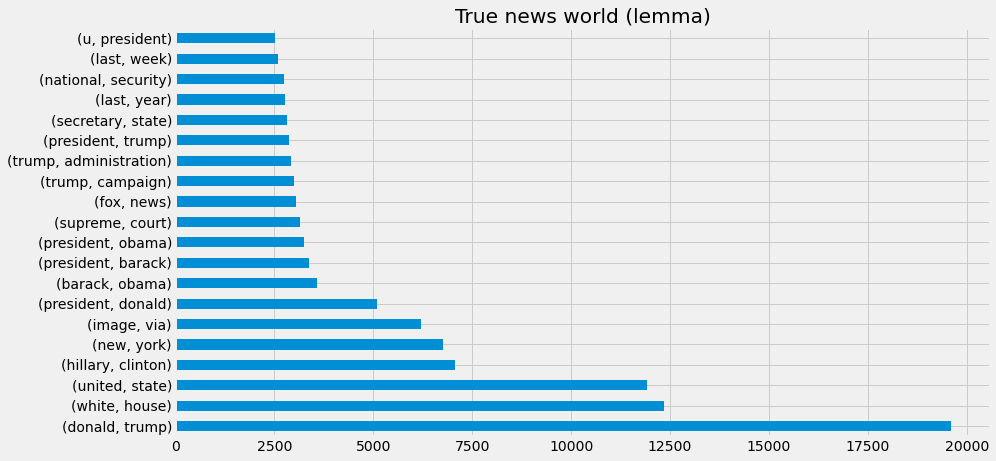

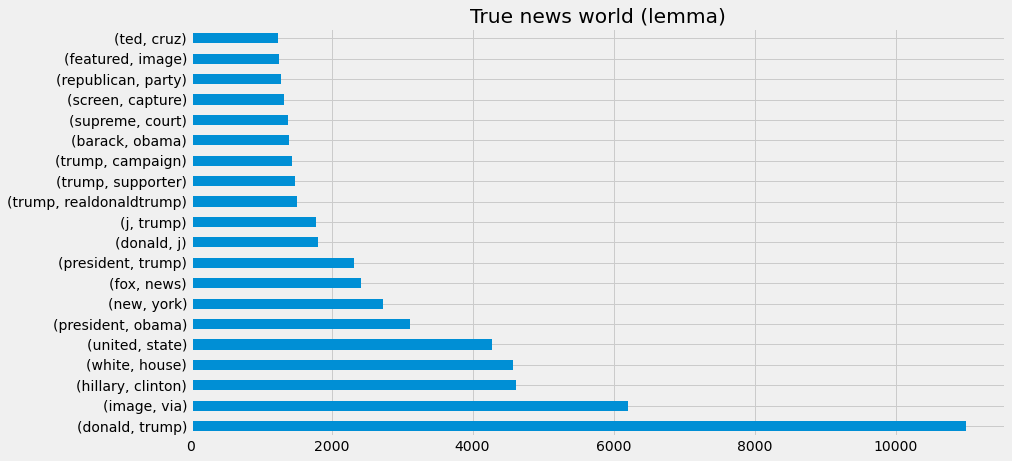

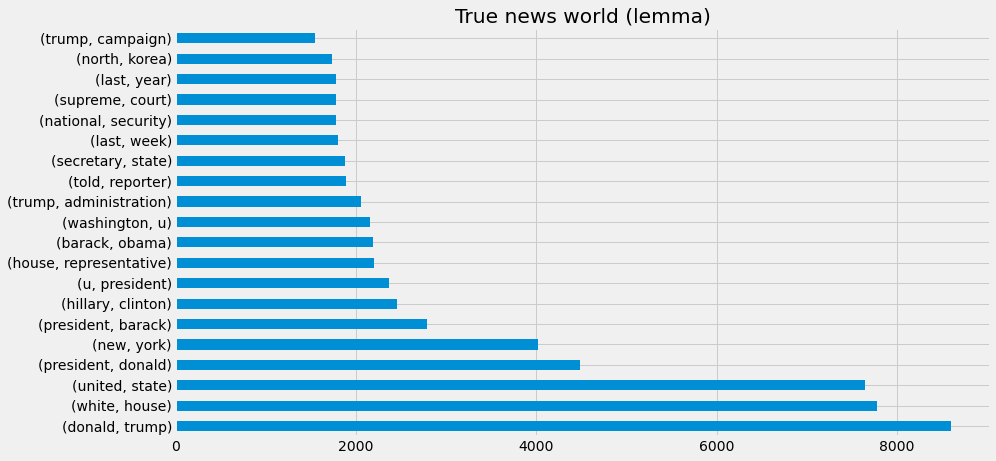

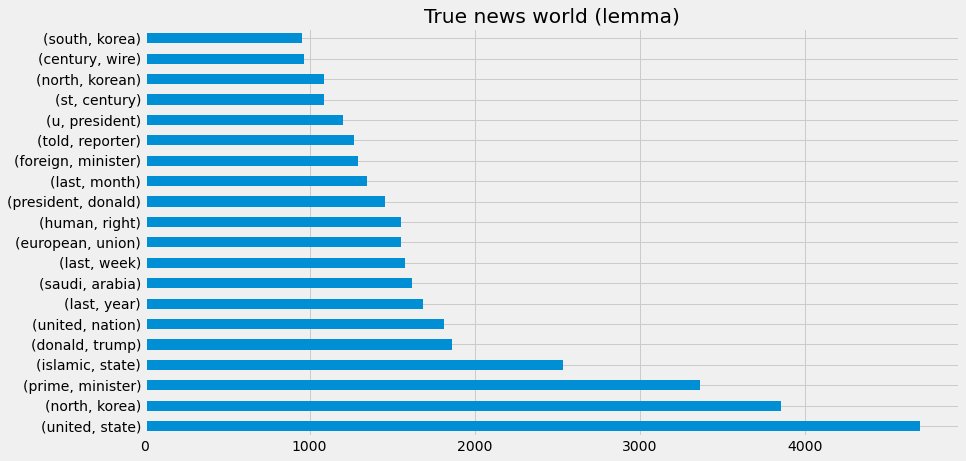

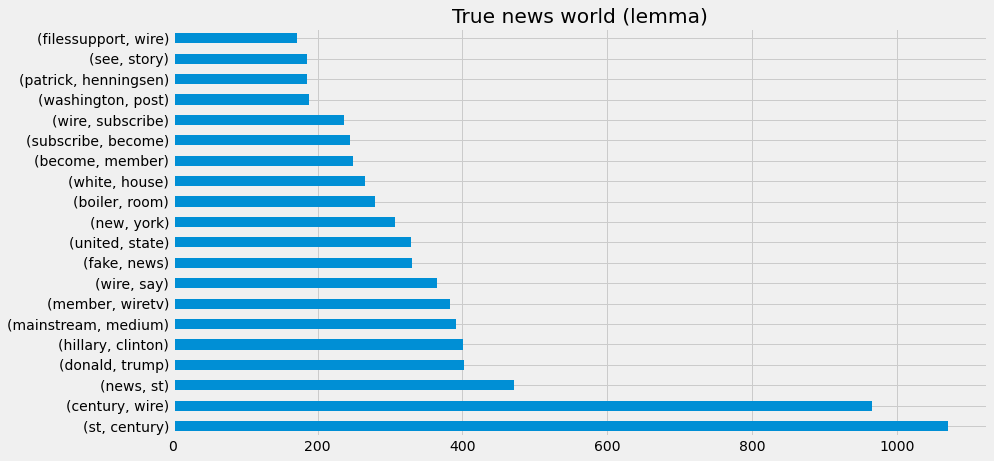

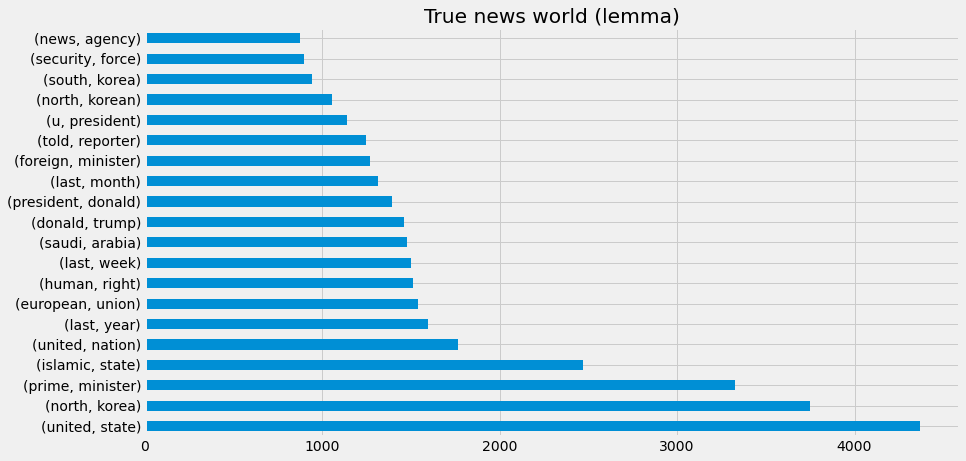

In [40]:
for corpus in article_corpora:
    corpus_freq = pd.Series(nltk.ngrams(corpus, 2)).value_counts().sort_values(ascending=False)
    
    plt.figure(figsize= (13,7))
    corpus_freq.head(20).plot.barh()
    title = corpus_title
    for i in title:
        plt.title(label=i)
    

    plt.show()

In [41]:
def top20_ngrams_viz(corpus, n_words, title=False):
    '''
    Takes in a corpus of words from the Fake News Detection dataset (df), an n number of words (n_words), and an optional title (string), 
    returns a horizontal bar graph of the top 20 most common occurrences of the word or group of words.
    '''
    corpus_freq = pd.Series(nltk.ngrams(corpus, n_words)).value_counts().sort_values(ascending=False)
    h_bar = corpus_freq.head(20).plot.barh()
    if title:
        plt.title(title)
    return h_bar

    

<AxesSubplot:title={'center':'Top 20 Trigrams in Politics Articles (lemma)'}>

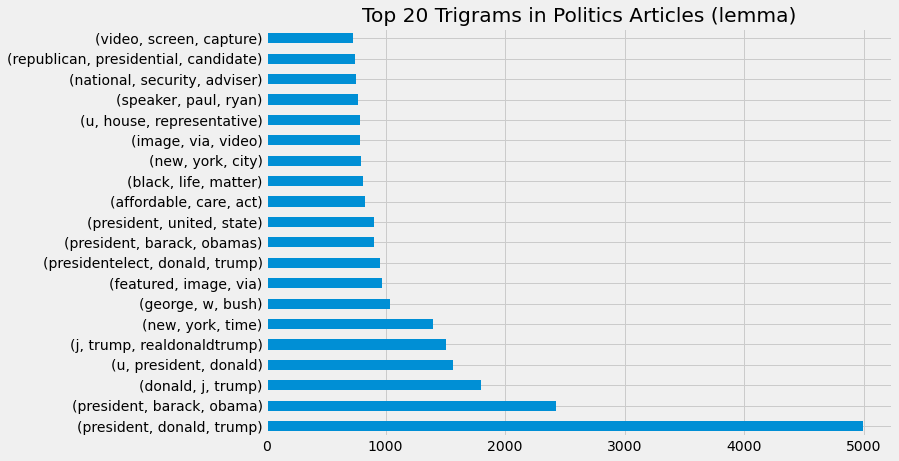

In [42]:
top20_ngrams_viz(pol_lem_corpus, 3, title='Top 20 Trigrams in Politics Articles (lemma)')

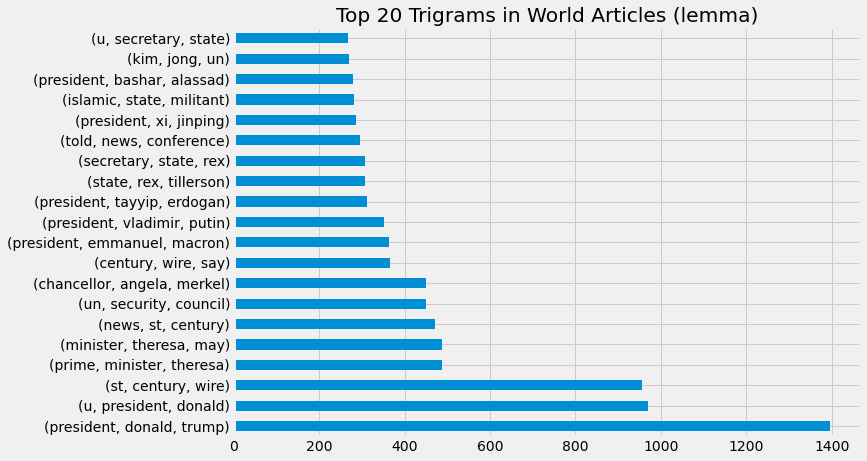

In [43]:
top20_ngrams_viz(world_lem_corpus, 3, title='Top 20 Trigrams in World Articles (lemma)')
plt.show()

In [46]:
df['truth_label'] = df.truth_value.astype('str')
df.head(3)

,article_headline,article_body,subject,truth_value,article_clean,raw_wd_count,article_stemmed,article_lemmatized,truth_label
date,,,,,,,,,
2015-03-31,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,False,case missed sen harry reid rnv announced last ...,123,case miss sen harri reid rnv announc last week...,case missed sen harry reid rnv announced last ...,False
2015-03-31,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,False,anyone really think hillary clinton come clean...,493,doe anyon realli think hillari clinton come cl...,doe anyone really think hillary clinton come c...,False
2015-03-31,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,False,irony lost us hillary compared president wante...,322,ironi lost us hillari compar presid want take ...,irony lost u hillary compared president wanted...,False


In [47]:
u_articles = df[df.article_lemmatized.str.contains(' u ')]
u_articles[u_articles.truth_label == 'True'].article_lemmatized[0]

'ames iowa u democratic presidential candidate hillary clinton tuesday expanded plan tax wealthiest american saying close taxavoidance loophole allow investment routed lowtax country put taxdeferred retirement account plan kind simple go wealthy pay middleclass working people poor people need clinton campaign stop ames iowa tuesday think thats smart way help fund priority clinton added clinton end bermuda reinsurance loophole allows hedge fund manager route investment insurance company lowtax country bermuda avoid paying higher tax rate clinton close call romney loophole allows wealthy individual shield large sum money individual retirement account taxation proposal come plan announced monday add percent incometax surcharge earner million per year clinton reiterated support buffett rule named billionaire investor clinton endorser warren buffett institute minimum tax rate percent earning million per year clinton long democratic party frontrunner nomination unveiling plan tax wealthy ami

### Takeaways: Clear themes in bigrams and trigrams. Common word 'u' appears to be the result of NLP on the string 'U.S.'. Minor issue getting proper titles on n-gram viz automation still WIP.

### Start bivariate/multivariate exploration

- Make train/validate/test splits

In [49]:
train_size = .50
validate_size = .30
n = df.shape[0]
validate_start_index = round(train_size * n)
test_start_index = round((train_size + validate_size) * n)

train = df[:validate_start_index] # everything up (not including) to the validate_start_index
validate = df[validate_start_index:test_start_index] # everything from validate_start_index to test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

In [51]:
# Check that split lengths are appropriate
len(train) + len(validate) + len(test) == len(df)

True

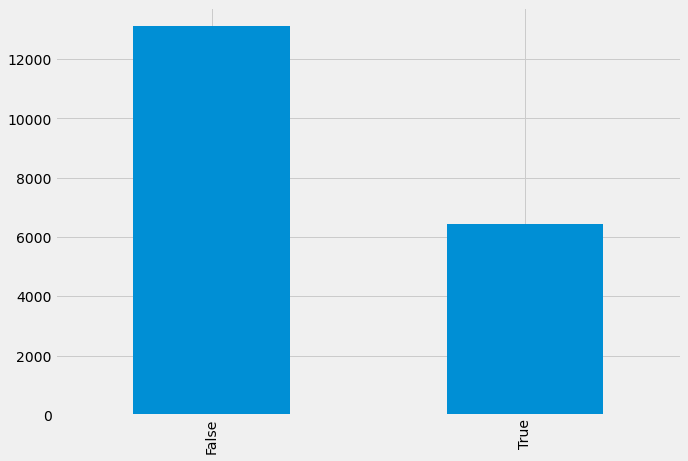

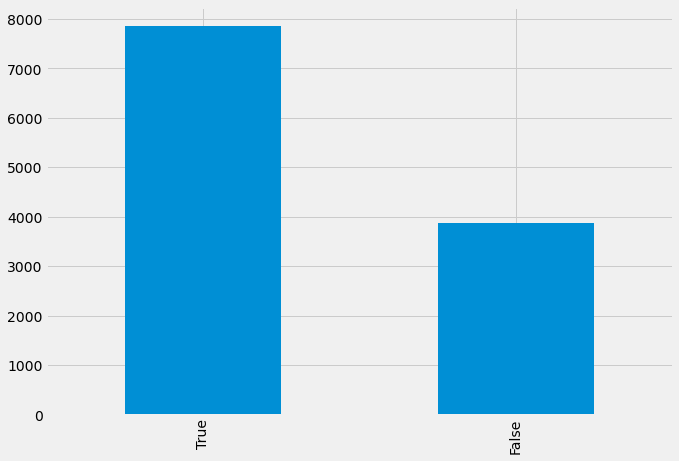

<AxesSubplot:>

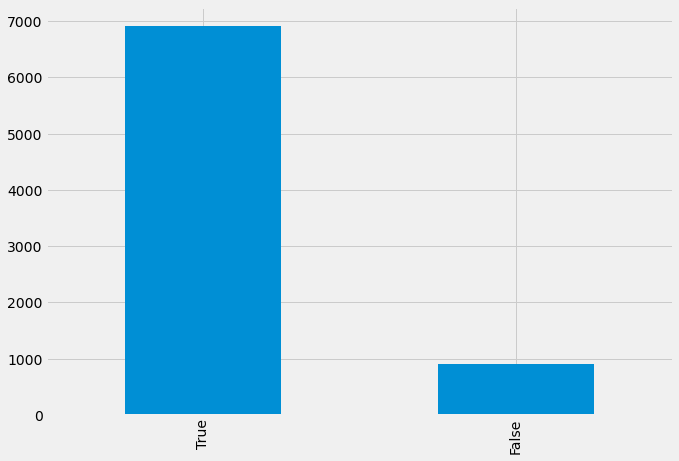

In [59]:
train.truth_label.value_counts().plot.bar()
plt.show()
validate.truth_label.value_counts().plot.bar()
plt.show()
test.truth_label.value_counts().plot.bar()
